In [1]:
import itertools
import math
from functools import partial

import fontTools
import geopandas as gpd
import numpy as np
import pandas as pd
import vsketch
from fn.fn import new_savepath
from fontTools.ttLib import TTFont
from geodude.fonts import (download_font, extract_glyph_points,
                           get_character_polygon, get_font_path, get_glyph)
from geodude.intersection import (
    assign_psuedoperiodic_order_to_adjacent_clusters,
    assign_random_order_to_adjacent_clusters,
    chunked_pairwise_partition_polygons, find_adjacency_clusters,
    find_contained_polys, find_intersecting_polys, find_parent_polygons,
    find_touching_polys, merge_disjoint_polys, pairwise_partition_polygons)
from geodude.line import bezier_func, dash_linestring
from geodude.ops import (buft_fill, form_affine_basis,
                         get_affine_transformation, make_like)
from geodude.parameter import Prm, prms
from geodude.subdivide import (bino_draw, flex_rule_recursive_split,
                               random_line_subdivide,
                               random_line_subdivide_gen,
                               split_along_longest_side_of_min_rectangle,
                               split_poly)
from geodude.utils import (Paper, flatten_geoms, merge_LineStrings,
                           merge_Polygons)
from matplotlib import pyplot as plt
from shapely import is_valid, unary_union
from shapely.affinity import affine_transform, rotate, scale, translate
from shapely.geometry import (LineString, MultiLineString, MultiPoint,
                              MultiPolygon, Point, Polygon, box)
from shapely.ops import nearest_points

%load_ext autoreload
%autoreload 2

In [2]:
download_font("EB Garamond")

EB Garamond downloaded successfully to /Users/alexandernaka/code/art/brr/libraries/geodude/geodude/assets/fonts/EB_Garamond/EB_Garamond.zip!
EB Garamond unzipped successfully in /Users/alexandernaka/code/art/brr/libraries/geodude/geodude/assets/fonts/EB_Garamond!


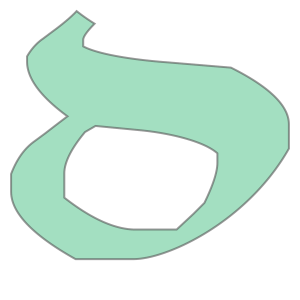

In [23]:
get_character_polygon(font_name = 'EBGaramond-Bold', glyph_name = 'g', n_points = 200)

In [4]:
def get_glyph_set(font_name):
    """
    Retrieves the glyph set from a TrueType font.

    Args:
        font_name (str): The name of the font.

    Returns:
        fontTools.ttLib.ttFont.GlyphSet: The GlyphSet object for the font.
    """
    font_path = get_font_path(font_name)
    font = TTFont(font_path)
    glyph_set = font.getGlyphSet()
    return glyph_set


def substring(line, start_dist, end_dist):
    """
    Retrieves a substring of a line.

    Args:
        line (shapely.geometry.LineString): The line to substring.
        start_dist (float): The distance along the line to start the substring.
        end_dist (float): The distance along the line to end the substring.

    Returns:
        shapely.geometry.LineString: The substring of the line.
    """
    # Ensure the start distance is smaller than the end distance
    if start_dist > end_dist:
        start_dist, end_dist = end_dist, start_dist

    # Interpolate the start and end points
    start_point = line.interpolate(start_dist)
    end_point = line.interpolate(end_dist)

    # Get the coordinates of the line
    coords = list(line.coords)

    # Find the index of the start point
    start_index = 0
    for i in range(len(coords) - 1):
        if LineString(coords[i:i+2]).distance(start_point) == 0:
            start_index = i
            break

    # Find the index of the end point
    end_index = len(coords) - 1
    for i in range(len(coords) - 1, 0, -1):
        if LineString(coords[i-1:i+1]).distance(end_point) == 0:
            end_index = i
            break

    # Return a new line string from the start to the end point
    return LineString(coords[start_index:end_index+1])


def place_text_on_path(text, font_name, line, start_dist=0, end_dist=None, n_points=100):
    """
    Places the specified text on a line.

    Args:
        text (str): The text to place.
        font_name (str): Name of the font to use.
        line (shapely.geometry.LineString): The line to place the text on.
        start_dist (float): The distance along the line to start the text.
        end_dist (float): The distance along the line to end the text. If not specified, the text will end at the end of the line.
        n_points (int): Number of points to sample from each glyph.

    Returns:
        list: A list of polygons representing the characters of the text.
    """
    if end_dist is None:
        end_dist = line.length

    # Calculate the total length of the text
    total_length = end_dist - start_dist

    # Get the font and glyph set
    font_path = get_font_path(font_name)
    font = fontTools.ttLib.TTFont(font_path)
    glyph_set = font.getGlyphSet()

    # Estimate the width of a space
    space_width = font['head'].unitsPerEm / 4

    # Calculate the width of each character
    char_widths = []
    for char in text:
        if char == " ":
            char_widths.append(space_width)
        else:
            try:
                # glyph_name = f"uni{ord(char):04X}"
                # glyph = glyph_set[glyph_name]
                glyph = get_glyph(font_name, char)
                char_widths.append(glyph.width)
            except:
                print(char)
    total_width = sum(char_widths)

    # Calculate the scale factor
    scale_factor = total_length / total_width

    # Scale the character widths
    char_widths = [width * scale_factor for width in char_widths]

    # Create a list to store the polygons
    polygons = []

    # For each character in the text
    for i, char in enumerate(text):
        
        # Calculate the start and end of the character
        char_start = start_dist + sum(char_widths[:i])
        char_end = char_start + char_widths[i]
        if char != " ":
            # Get a line for the character
            char_line = substring(line, char_start, char_end)
            position = char_line.interpolate(0.5, normalized=True)
            direction = np.array(char_line.coords[-1]) - np.array(char_line.coords[0])
            angle = math.atan2(direction[1], direction[0])

            # Get the polygon for the glyph
            glyph_polygon = get_character_polygon(font_name, char, n_points=n_points)

            # Position the polygon
            glyph_polygon = translate(glyph_polygon, xoff=position.x, yoff=position.y)
            glyph_polygon = rotate(glyph_polygon, angle, origin='centroid')

            # Add the polygon to the list
            polygons.append(glyph_polygon)

    return polygons

In [5]:
glyph_set = get_glyph_set('EBGaramond-Bold')

In [18]:
line = LineString([(0, 0), (1000, 100), (6000, 0)])
polygons = place_text_on_path("yo yo", 'EBGaramond-Bold', line)

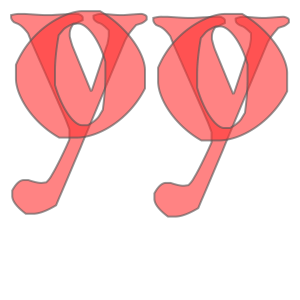

In [20]:
merge_Polygons(polygons)

# compositions

In [3]:
# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [70]:
chars = 'NONREPRESENTATIONALnonrepresentational' * 2

polys = []
for char in chars:
    try:
        poly = get_character_polygon(font_name = 'EBGaramond-Bold', glyph_name = char, n_points = 20)
        scale_factor = np.random.uniform(0.05, 0.6)
        poly = scale(poly, xfact=scale_factor, yfact=scale_factor)
        poly = translate(poly, xoff=np.random.uniform(-150, 150), yoff=np.random.uniform(-300, 300))
        polys.append(poly)
    except:
        pass

In [71]:
mp = MultiPolygon(polys)

In [72]:
gdf = gpd.GeoDataFrame({'geometry': polys})

In [73]:
disjoint = chunked_pairwise_partition_polygons(
    gdf, 
    chunk_size=10,
    min_area=1e-3,
    verbose=True,
    )

Iteration 1
Finding intersections in 74 polygons
1516 intersections remaining
Chunking polygons
Partitioning 8 chunks


8it [00:03,  2.26it/s]


Iteration 1 complete, 543 polygons remaining
Iteration 2
Finding intersections in 543 polygons
4758 intersections remaining
Chunking polygons
Partitioning 52 chunks


52it [00:04, 12.05it/s]


Iteration 2 complete, 1022 polygons remaining
Iteration 3
Finding intersections in 1022 polygons
6610 intersections remaining
Chunking polygons
Partitioning 96 chunks


96it [00:06, 15.35it/s]


Iteration 3 complete, 1611 polygons remaining
Iteration 4
Finding intersections in 1611 polygons
7870 intersections remaining
Chunking polygons
Partitioning 151 chunks


151it [00:08, 17.13it/s]


Iteration 4 complete, 2100 polygons remaining
Iteration 5
Finding intersections in 2100 polygons
7650 intersections remaining
Chunking polygons
Partitioning 189 chunks


189it [00:09, 19.99it/s]


Iteration 5 complete, 2371 polygons remaining
Iteration 6
Finding intersections in 2371 polygons
6768 intersections remaining
Chunking polygons
Partitioning 203 chunks


203it [00:08, 24.08it/s]


Iteration 6 complete, 2346 polygons remaining
Iteration 7
Finding intersections in 2346 polygons
5562 intersections remaining
Chunking polygons
Partitioning 194 chunks


194it [00:07, 27.67it/s]


Iteration 7 complete, 2160 polygons remaining
Iteration 8
Finding intersections in 2160 polygons
4548 intersections remaining
Chunking polygons
Partitioning 177 chunks


177it [00:05, 29.89it/s]


Iteration 8 complete, 1923 polygons remaining
Iteration 9
Finding intersections in 1923 polygons
3682 intersections remaining
Chunking polygons
Partitioning 159 chunks


159it [00:04, 36.02it/s]


Iteration 9 complete, 1664 polygons remaining
Iteration 10
Finding intersections in 1664 polygons
2990 intersections remaining
Chunking polygons
Partitioning 137 chunks


137it [00:02, 46.61it/s] 


Iteration 10 complete, 1414 polygons remaining
Iteration 11
Finding intersections in 1414 polygons
2600 intersections remaining
Chunking polygons
Partitioning 121 chunks


121it [00:02, 48.39it/s] 


Iteration 11 complete, 1250 polygons remaining
Iteration 12
Finding intersections in 1250 polygons
2312 intersections remaining
Chunking polygons
Partitioning 110 chunks


110it [00:02, 46.95it/s]


Iteration 12 complete, 1142 polygons remaining
Iteration 13
Finding intersections in 1142 polygons
2102 intersections remaining
Chunking polygons
Partitioning 103 chunks


103it [00:02, 46.26it/s] 


Iteration 13 complete, 1063 polygons remaining
Iteration 14
Finding intersections in 1063 polygons
1860 intersections remaining
Chunking polygons
Partitioning 94 chunks


94it [00:01, 56.86it/s]


Iteration 14 complete, 952 polygons remaining
Iteration 15
Finding intersections in 952 polygons
1698 intersections remaining
Chunking polygons
Partitioning 86 chunks


86it [00:01, 65.90it/s] 


Iteration 15 complete, 869 polygons remaining
Iteration 16
Finding intersections in 869 polygons
1602 intersections remaining
Chunking polygons
Partitioning 81 chunks


81it [00:01, 59.45it/s]


Iteration 16 complete, 829 polygons remaining
Iteration 17
Finding intersections in 829 polygons
1472 intersections remaining
Chunking polygons
Partitioning 76 chunks


76it [00:01, 53.84it/s]


Iteration 17 complete, 777 polygons remaining
Iteration 18
Finding intersections in 777 polygons
1326 intersections remaining
Chunking polygons
Partitioning 69 chunks


69it [00:01, 56.91it/s]


Iteration 18 complete, 698 polygons remaining
Iteration 19
Finding intersections in 698 polygons
1200 intersections remaining
Chunking polygons
Partitioning 63 chunks


63it [00:01, 52.99it/s]


Iteration 19 complete, 632 polygons remaining
Iteration 20
Finding intersections in 632 polygons
1088 intersections remaining
Chunking polygons
Partitioning 56 chunks


56it [00:00, 57.54it/s]


Iteration 20 complete, 578 polygons remaining
Iteration 21
Finding intersections in 578 polygons
994 intersections remaining
Chunking polygons
Partitioning 52 chunks


52it [00:01, 38.91it/s]


Iteration 21 complete, 553 polygons remaining
Iteration 22
Finding intersections in 553 polygons
820 intersections remaining
Chunking polygons
Partitioning 45 chunks


45it [00:01, 35.37it/s]


Iteration 22 complete, 454 polygons remaining
Iteration 23
Finding intersections in 454 polygons
636 intersections remaining
Chunking polygons
Partitioning 35 chunks


35it [00:00, 43.75it/s]


Iteration 23 complete, 353 polygons remaining
Iteration 24
Finding intersections in 353 polygons
532 intersections remaining
Chunking polygons
Partitioning 29 chunks


29it [00:00, 45.98it/s]


Iteration 24 complete, 287 polygons remaining
Iteration 25
Finding intersections in 287 polygons
450 intersections remaining
Chunking polygons
Partitioning 24 chunks


24it [00:00, 48.32it/s]


Iteration 25 complete, 239 polygons remaining
Iteration 26
Finding intersections in 239 polygons
406 intersections remaining
Chunking polygons
Partitioning 21 chunks


21it [00:00, 55.95it/s]


Iteration 26 complete, 207 polygons remaining
Iteration 27
Finding intersections in 207 polygons
374 intersections remaining
Chunking polygons
Partitioning 19 chunks


19it [00:00, 63.18it/s]


Iteration 27 complete, 192 polygons remaining
Iteration 28
Finding intersections in 192 polygons
356 intersections remaining
Chunking polygons
Partitioning 19 chunks


19it [00:00, 47.42it/s]


Iteration 28 complete, 182 polygons remaining
Iteration 29
Finding intersections in 182 polygons
316 intersections remaining
Chunking polygons
Partitioning 17 chunks


17it [00:00, 57.79it/s]


Iteration 29 complete, 167 polygons remaining
Iteration 30
Finding intersections in 167 polygons
292 intersections remaining
Chunking polygons
Partitioning 16 chunks


16it [00:00, 36.19it/s]


Iteration 30 complete, 170 polygons remaining
Iteration 31
Finding intersections in 170 polygons
238 intersections remaining
Chunking polygons
Partitioning 14 chunks


14it [00:00, 20.26it/s]


Iteration 31 complete, 147 polygons remaining
Iteration 32
Finding intersections in 147 polygons
124 intersections remaining
Chunking polygons
Partitioning 9 chunks


9it [00:00, 30.30it/s]


Iteration 32 complete, 76 polygons remaining
Iteration 33
Finding intersections in 76 polygons
60 intersections remaining
Chunking polygons
Partitioning 4 chunks


4it [00:00, 17.40it/s]


Iteration 33 complete, 39 polygons remaining
Iteration 34
Finding intersections in 39 polygons
16 intersections remaining
Chunking polygons
Partitioning 2 chunks


2it [00:00, 27.81it/s]


Iteration 34 complete, 10 polygons remaining
Iteration 35
Finding intersections in 10 polygons
2 intersections remaining
Chunking polygons
Partitioning 1 chunks


1it [00:00, 74.10it/s]

Iteration 35 complete, 2 polygons remaining
Iteration 36
Finding intersections in 2 polygons
0 intersections remaining
Chunking polygons


In [74]:
disjoint = find_parent_polygons(disjoint=disjoint, original=gdf)

disjoint = assign_random_order_to_adjacent_clusters(disjoint)

In [75]:
ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 1e-4
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

In [76]:
ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-9) & ~ngdf.is_empty
# idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss)
mls = make_like(mls, drawbox)

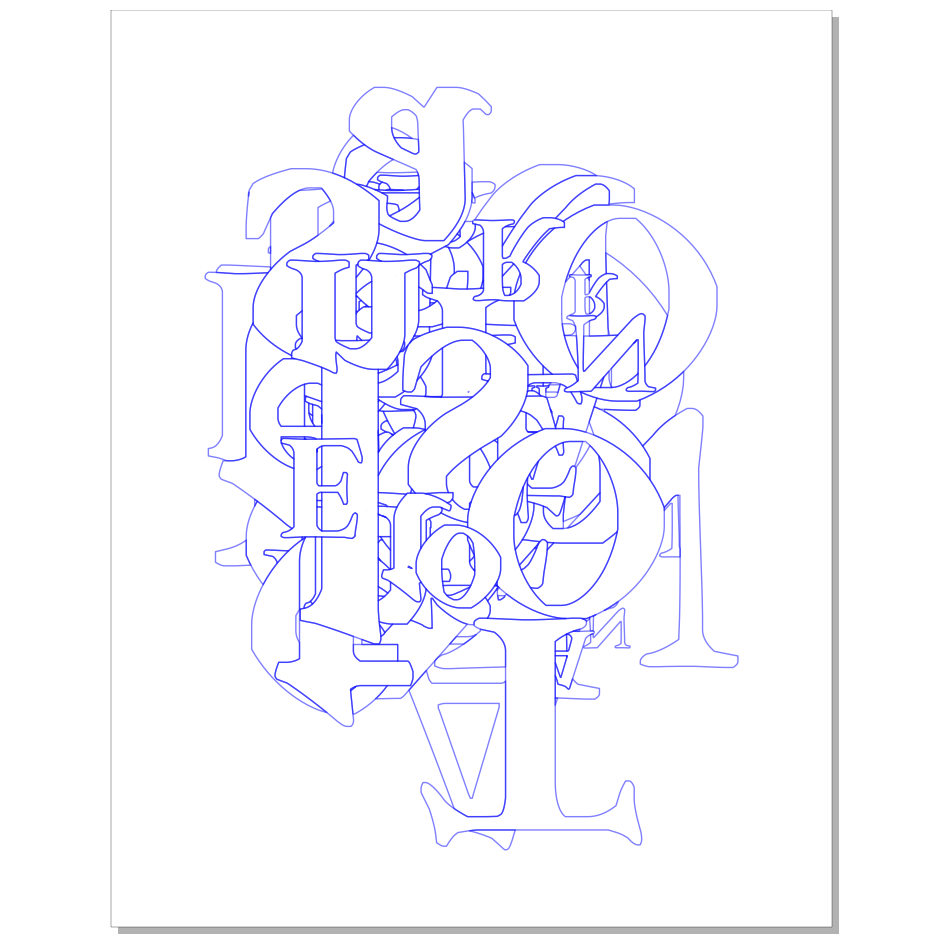

In [77]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(mls)
sk.display(fig_size=(12,12))

In [65]:
fills = []
for geom in gdf.geometry:
    d_buffer = Prm(np.random.uniform(-1.5, -0.1))
    d_translate = Prm(lambda : d_buffer() * np.random.uniform(0.4, 0.9))
    deg = Prm(np.random.uniform(230, 260))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=200)
    fills.append(polys.boundary)
fill_gdf = gpd.GeoDataFrame(geometry=fills)

In [66]:
sampled_ngdf = ngdf.sample(frac=1., replace=False)

In [67]:
masked = []

for ii, row in fill_gdf.iterrows():
    fill = row.geometry
    mask = sampled_ngdf.query('parent == @ii').geometry.buffer(1e-6)
    masked.append(fill.intersection(mask))
    masked.append(mask.boundary)
masked = pd.concat(masked)
masked = masked[~masked.is_empty]
fill_mls = merge_LineStrings(masked.to_list())

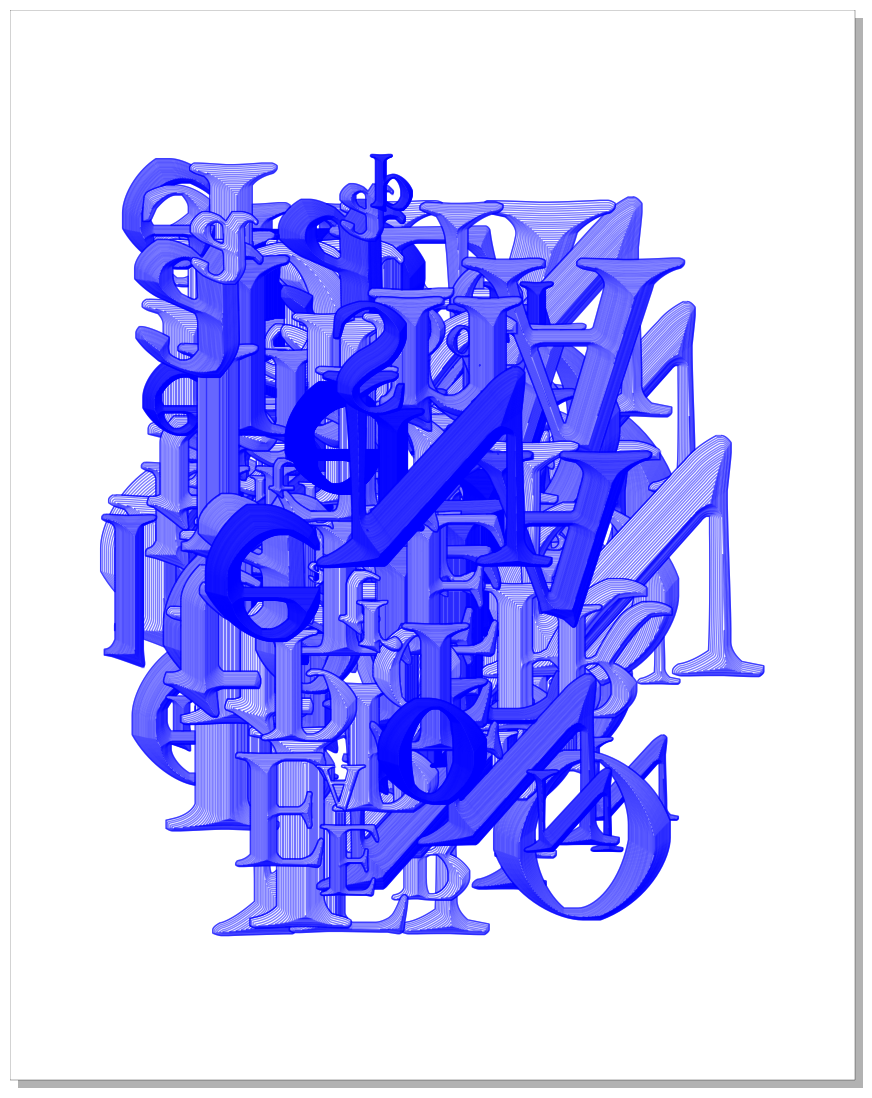

In [68]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(fill_mls, drawbox))
sk.display(fig_size=(11, 14))

In [69]:
sk.vpype('linesort')
fp = new_savepath(postfix='nonrepresentational')
sk.save(fp)